In [1]:
import torch
from deepchopper import  remove_intervals_and_keep_left, smooth_label_region, summary_predict, get_label_region

In [2]:
import deepchopper

In [3]:
from deepchopper.utils import alignment_predict, highlight_target, highlight_targets
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import logging
from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=FORMAT,
    handlers=[RichHandler()],
)

**TODO**: 

- [ ] summary chop  or not chop
- [ ] summary chop internal or terminal
- [ ] chop only has one interval
- [ ] summary chop interval size

In [17]:
@dataclass
class FqRecord:
    id: str
    seq: str
    qual: str

    def to_str(self):
        return f"{self.id}\n{self.seq}\n+\n{self.qual}"

def vis_qual_static(predict, start: int | None = None, end: int | None = None, figure_size=(20, 1)):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    start = 0 if start is None else start
    end = len(predict.seq) if end is None else end

    qual = np.array([ord(c) - 33 for c in list(predict.qual[start:end])]).reshape(1, -1)
    seq = list(predict.seq[start:end])

    # Creating the heatmap
    fig, ax = plt.subplots(figsize=figure_size)  # Set a wide figure to accommodate the sequence
    cax = ax.imshow(qual, aspect="auto", cmap="viridis")
    cbar = plt.colorbar(cax, ax=ax, orientation="vertical")
    cbar.set_label("Value")
    # Setting up the sequence as x-axis labels
    ax.set_xticks(np.arange(len(seq)))
    ax.set_xticklabels(seq, rotation=90)  # Rotate labels for better readability
    # Remove y-axis labels as there's only one row
    ax.set_yticks([])
    ax.set_title(f"{predict.id}: {start}-{end}")
    plt.close()


def print_seq(predict,  regions ):
    print(f"id     : {predict.id}")
    print(f"regions: {regions}")
    highlight_targets(predict.seq, regions)

def compare_smooth(predict, smooth_window_size: int):
    regions = predict.prediction_region

    window_size = smooth_window_size
    smooth_regions = predict.smooth_prediction_region(window_size)

    print(f"id      : {predict.id}")
    print(f"original: {regions}")
    print(f"smooth  : {smooth_regions}")
    highlight_targets(predict.seq, regions)
    highlight_targets(predict.seq, smooth_regions)

def chop_intervals(predict, *, smooth: bool, smooth_window_size: int | None) -> list[tuple[int, int]]:
    if smooth:
        if smooth_window_size is None:
            raise ValueError("please provide window size")
        window_size = smooth_window_size
        regions = predict.smooth_prediction_region(window_size)
    else:
        regions = predict.prediction_region
    return regions

def to_fqs_record(predict, intervals: list[tuple[int, int]]):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    assert len(predict.qual) == len(self.seq)

    seqs, saved_intervals = remove_intervals_and_keep_left(predict.seq, intervals)
    quals, saved_intervals = remove_intervals_and_keep_left(predict.qual, intervals)

    assert len(seqs) == len(quals)
    for ind, (seq, qual) in enumerate(zip(seqs, quals, strict=True)):
        record_id = f"@{predict.id}|{saved_intervals[ind][0], saved_intervals[ind][1]}"
        yield FqRecord(id=record_id, seq=seq, qual=qual)

def smooth_and_select_intervals(
    predict_id,
    stats,
    smooth_window_size: int,
    min_interval_length: int,
    approved_interval_nums: int = 1,
) -> list[tuple[int, int]]:    
    chop_intervals =  stats.smooth_intervals[predict.id] 

    results = []
    for interval in chop_intervals:
        if interval[1] - interval[0] > min_interval_length:
            results.append(interval)

    if len(results) > approved_interval_nums:
        return []

    return results

In [18]:
from needletail import parse_fastx_file, NeedletailError, reverse_complement, normalize_seq

def collect_fq_records(file: Path):
    result = {}
    try:
        for record in parse_fastx_file(file.as_posix()):
            result[record.id]  = record
    except NeedletailError:
        print("Invalid Fastq file")

    return result

In [19]:
import pysam
def collect_sam_records(file: Path):
    if not isinstance(file, Path):
        file = Path(file)
    
    result = {}
    samfile = pysam.AlignmentFile(file.as_posix(), "rb")

    for read in samfile.fetch():
        result[read.query_name]  = read 

    return result 

In [7]:
sam_records = collect_sam_records("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam")

In [8]:
len(sam_records)

8201131

In [9]:
test_chunks = [Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk0"),
               Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk1")]       

In [10]:
fq_records = collect_fq_records(Path("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.fastq"))

In [11]:
len(fq_records)

9177639

In [12]:
## VCaP
hyena_results = [
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_1/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_2/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_3/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_4/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_5/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_6/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_7/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_8/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_9/predicts/0/"),
]

In [13]:
max_batches  = 100
all_predicts = deepchopper.load_predicts_from_batch_pts(hyena_results[0],
                                                        -100, 
                                                        max_batches)

[04/18/24 20:11:30] INFO     Found 31250 pt files                                                    ]8;id=206054;file://src/smooth/predict.rs\predict.rs]8;;\:]8;id=353555;file://src/smooth/predict.rs#200\200]8;;\

                    INFO     only load first 1000 files                                              ]8;id=294829;file://src/smooth/predict.rs\predict.rs]8;;\:]8;id=605042;file://src/smooth/predict.rs#204\204]8;;\

In [14]:
len(all_predicts)

32000

In [15]:
stats = deepchopper.py_collect_statistics_for_predicts(
    list(all_predicts.values()), 
    smooth_window_size=11, 
                                               min_interval_size=7,
                                               approved_interval_number=5,
                                               internal_threshold=0.7,
                                               ploya_threshold=3
                                              )

In [16]:
stats

StatResult(total_predicts: 32000,  predicts_with_chop: 28689, smooth_predicts_with_chop: 28177,
                        total_truncated: 0, smooth_only_one: 27460, smooth_ploya_only_one: 22318)

In [20]:
print_seq(all_predicts[stats.predicts_with_chop[0]], stats.smooth_intervals[stats.predicts_with_chop[0]])

id     : 6a77f84b-271a-44e3-ae72-17cd2681e3dc
regions: [(490, 556)]


GCGCTGGCCACGGAGGTGGCAGCCATCTCCTCTCGGCATCATGGCCGCCCTCAGACCCCTTGTGAAGCCCAAGATCGTCAAAAAGAGAACCAAGAAGTTCATCCGGCACCAGTCA
GACCGATATGTCAAAATTAAGCGTAACTGGCGGAAACCCAGAGGCATTGACAACAGGGTTCGTAGAAGATTCAAGGGCCAGATCTTGATGCCCAACATTGGTTATGGAAGCAACA
AAAAACAAAGCACATGCTGCCCAGTGGCTTTCCGGAAGTTCCTGGTCCTAACGTCAAGGAGCTGGAAGTGCTGCTGATGTGCATAACAAATCTGTGCCGAGATCGCTCACAATGT
TTCCTCCAAGAACCGCAAAGCCATCGTGGAAAGAGCTGCCCAACTGGCCAAGAGTCACCAACCCCAATGCCAGGCTGCGCAGTGAAGAAATGAGTAGGCAGCTCATGTGCTCATC
TTCTGTTTAAATAATGTAAACTGCCAAAAACAAAAAAATCCCTCCCATCCATGCCCACCGTTATCATCCATATCATCCATCCCATCCTAATCACCC

In [21]:
print(all_predicts[stats.predicts_with_chop[0]].show_info(stats.smooth_intervals) )

id: 6a77f84b-271a-44e3-ae72-17cd2681e3dc
prediction: [490..556]
smooth_intervals: Some([(490, 556)])
GCGCTGGCCACGGAGGTGGCAGCCATCTCCTCTCGGCATCATGGCCGCCCTCAGACCCCTTGTGAAGCCCAAGATCGTCA
AAAAGAGAACCAAGAAGTTCATCCGGCACCAGTCAGACCGATATGTCAAAATTAAGCGTAACTGGCGGAAACCCAGAGGC
ATTGACAACAGGGTTCGTAGAAGATTCAAGGGCCAGATCTTGATGCCCAACATTGGTTATGGAAGCAACAAAAAACAAAG
CACATGCTGCCCAGTGGCTTTCCGGAAGTTCCTGGTCCTAACGTCAAGGAGCTGGAAGTGCTGCTGATGTGCATAACAAA
TCTGTGCCGAGATCGCTCACAATGTTTCCTCCAAGAACCGCAAAGCCATCGTGGAAAGAGCTGCCCAACTGGCCAAGAGT
CACCAACCCCAATGCCAGGCTGCGCAGTGAAGAAATGAGTAGGCAGCTCATGTGCTCATCTTCTGTTTAAATAATGTAAA
CTGCCAAAAACAAAAAAATCCCTCCCATCCATGCCCACCGTTATCATCCATATCATCCATCCCATCCTAATCACCC
GCGCTGGCCACGGAGGTGGCAGCCATCTCCTCTCGGCATCATGGCCGCCCTCAGACCCCTTGTGAAGCCCAAGATCGTCA
AAAAGAGAACCAAGAAGTTCATCCGGCACCAGTCAGACCGATATGTCAAAATTAAGCGTAACTGGCGGAAACCCAGAGGC
ATTGACAACAGGGTTCGTAGAAGATTCAAGGGCCAGATCTTGATGCCCAACATTGGTTATGGAAGCAACAAAAAACAAAG
CACATGCTGCCCAGTGGCTTTCCGGAAGTTCCTGGTCCTAACGTCAAGGAGCTGGAAGTGCTGCTGATGTGCATAACAAA
TCTGTGCCGAGA

In [22]:
for pid, p in all_predicts.items():
    p.qual =  fq_records[p.id].qual

In [23]:
len(stats.smooth_internal_predicts)

458

In [27]:
for p in stats.smooth_internal_predicts:
    pd = all_predicts[p]
    sreg = stats.smooth_intervals.get(p, [])

    if len(sreg) >=2:
        print("\n")
        print(pd.show_info(stats.smooth_intervals))

    # smooth_reg = stats.smooth_intervals.get(p, []) 
    # oreg = pd.prediction_region()

    # print(f"orignal:{oreg}")
    # print(f"smooth: {smooth_reg}")

    # highlight_targets(pd.seq, oreg)
    # highlight_targets(pd.seq, smooth_reg)



id: ca4ecff3-a785-471d-b412-a0d7609bee08
prediction: [158..159, 179..251, 3341..3343, 3344..3371, 3374..3418, 3995..4002]
smooth_intervals: Some([(179, 251), (3342, 3418), (3995, 4007)])
TTGGGAAAAGTGTTATTATTTGGCATGCTTAAATTGAATAAGTATTCTCATCAGCATTTAATAAATGTATAGGCAGATGT
AAAGGTAATTTTGTGTATTTTGAGATAATGTCAAAATCATGAATATTTCAAAATAAACTGGGGAGTTATAAAAAAATACA
ACTAGAGATATAAAAAAAATCCCACCTCCCACCTCCAACCCATCTTATCCACTACATCTTCTTATCCCATCCCAACCCAT
TTTTCCCCCCTTGGGGTGTTCCCAAGACCTGGGGGACGACAGACATTCAGGGAGGAAGATGAGATGACTTTGCATCCCCG
GGAGTGGGTGCAGCCTCACTTGGGGATGGGCTTTACTTGATGCAACCTCATCTCTGAGATGGGCAACTTGGTGGGTGGTG
GCTTATAACTGTAAGGGAGATGGCAGCCCCAGGGTACAGCCAGCAGGCATTGAGCAGCCTCTAGCATTGTCCCCCTACTC
CCGTCCAGGTGTCCCCATCCCTCCCTGTCTCTTTGAGCTGGCTCTTGTCACTTAGGTCTCATCTCAGTGGCCGCTCCTGG
GCCACCCTGTCACCCAAGCTCTCCTGATTGCCCAGCCCTCTTGTTCTTCCACTTTGGCCTGTTTTGCTCCCTAGTGTCAC
TTATTACAGCTTGTGAGGCCAGGAGTTTGAGACCATCCTGGGCATCAATGAGACACCGTCTCTAAAAATAAATTAGCTGG
GTGTGGTGGTGCACCGCCTGTGGTCCCAGCTCCTCAGAGGTTGAGTAGAGGCTGAGGTGAGCGGAGCACTTGAAGCCAAG
A

In [15]:
p = stats.predicts_with_chop[0]
vis_qual_static(all_predicts[p], stats.smooth_intervals[p][0][0] - 10 , stats.smooth_intervals[p][0][1] + 10)

ValueError: no qual, please fetch qual first

In [57]:
import seaborn as sns
import numpy as np


def vis_hist_for_num_of_intervals(data, figsize=(10,6), title=None, ax=None, set_xticks=False):
    # Create histogram with a kernel density estimate
    max_x = max(data) + 1 
    if ax is None:
        plt.figure(figsize=figsize)
        sns.histplot(data, kde=True, color='#66c2a5', line_kws={'linewidth': 2}, discrete=True)
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel('Value')
        plt.ylabel('Frequency')
    else:
        sns.histplot(data, kde=True, color='#66c2a5', line_kws={'linewidth': 2}, discrete=True, ax=ax)
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

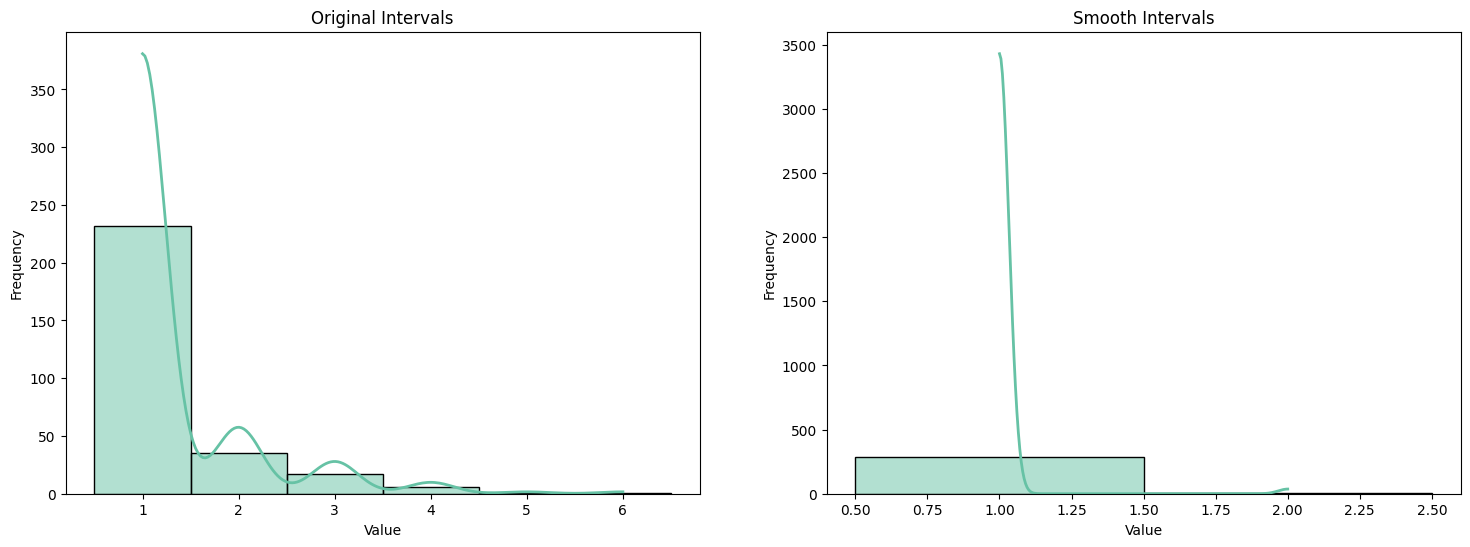

In [58]:
original_prediction_number = stats.number_predicts_with_chop(all_predicts)
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [47]:
len(stats.smooth_only_one_with_ploya)

233

In [55]:
plot_oregion_size_data = stats.length_predicts_with_chop(all_predicts)
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()

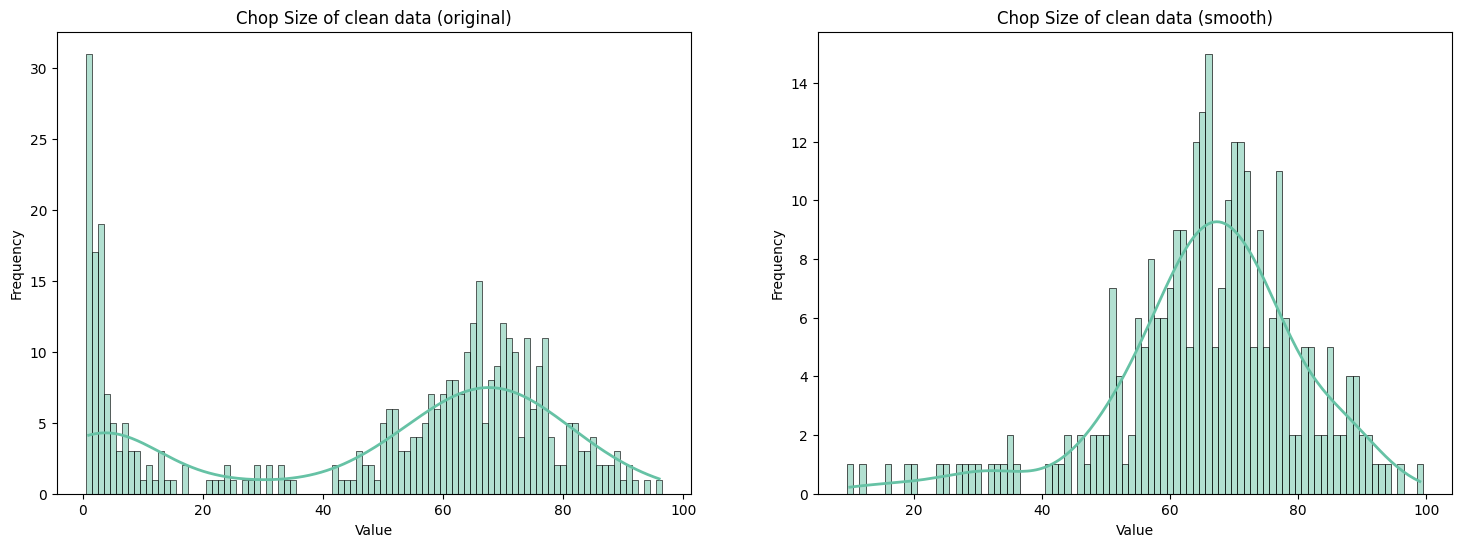

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(plot_oregion_size_data, title="Chop Size of clean data (original)", ax=axs[0])
vis_hist_for_num_of_intervals(plot_sregion_size_data, title="Chop Size of clean data (smooth)", ax=axs[1])

In [32]:
len(stats.smooth_only_one)

283

In [34]:
len(stats.smooth_predicts_with_chop)

286

In [ ]:
stats.smooth_intervals

In [80]:
def show_examples(predcit_ids, all_predicts, stats):
    for predict_id in predcit_ids:
        predict = all_predicts[predict_id] 
        smooth_regs = stats.smooth_intervals.get(predict_id, [])
        oreg = predict.prediction_region()
        print(f"id: {predict.id}\n{oreg=}\n{smooth_regs=}")
        highlight_targets(predict.seq, oreg)
        highlight_targets(predict.seq, smooth_regs)
        # print(predict)
        # print(smooth_regs)

In [81]:
show_examples(set(stats.smooth_predicts_with_chop) - set(stats.smooth_only_one), all_predicts, stats)

id: 1d6de1da-2f7a-4c1e-a62c-1aed18994d5f
oreg=[(69, 70), (79, 94), (97, 98), (545, 605)]
smooth_regs=[(79, 95), (545, 607)]


ATAAAAAAAAATTCCTCCTACCTCCTACTACACACATTCCCACCAACTTATCATCCATCATCTTACACAATCCATCCCACATCCTTACTATCCCCCTTGTCGCCATGACCGCCAC
GCGTGAGACTCTTCCGCCGCCTCCGCCGCAGACGCCGCCGCGATGCGCTCTACGTCGCCTCCTACCTGCTGTTGCCCTAGGGGCATTCTCCTCCCCAGCGCCAAGGACATCAAGA
AGATCAAATACCAGCGTGGGTATCGAGGCGGACGACGACCGGCTCAACAAGGTTATCAGTGAGCTGAATGGAAAAACATTGAAGACGTCATTGCCCTCAGGGTATTGGCAAGCTT
GCCAGTGTACCTGCTGGTGGGCTTGTAGCCGTCTCTGCTGCCCAGGCTCTGCAGCCCCTGCTGCTGGTTCTGCCCCTGCTGCAGCAGAGGAGAAGAAAGATGAGAAGAAGGAGGA
GTCTGAAGAGTCAGATGATGACATGGGATTTGGCCTTTTTGATTAAATTCCTGCTCCCTGCAAATAAAGCCTTTTACACAAAATTCCCTCCTCCTATCATCATCCATATCATCTC
ATTATCCACCACATATCACCTAAACTTTCCTC

ATAAAAAAAAATTCCTCCTACCTCCTACTACACACATTCCCACCAACTTATCATCCATCATCTTACACAATCCATCCCACATCCTTACTATCCCCCTTGTCGCCATGACCGCCAC
GCGTGAGACTCTTCCGCCGCCTCCGCCGCAGACGCCGCCGCGATGCGCTCTACGTCGCCTCCTACCTGCTGTTGCCCTAGGGGCATTCTCCTCCCCAGCGCCAAGGACATCAAGA
AGATCAAATACCAGCGTGGGTATCGAGGCGGACGACGACCGGCTCAACAAGGTTATCAGTGAGCTGAATGGAAAAACATTGAAGACGTCATTGCCCTCAGGGTATTGGCAAGCTT
GCCAGTGTACCTGCTGGTGGGCTTGTAGCCGTCTCTGCTGCCCAGGCTCTGCAGCCCCTGCTGCTGGTTCTGCCCCTGCTGCAGCAGAGGAGAAGAAAGATGAGAAGAAGGAGGA
GTCTGAAGAGTCAGATGATGACATGGGATTTGGCCTTTTTGATTAAATTCCTGCTCCCTGCAAATAAAGCCTTTTACACAAAATTCCCTCCTCCTATCATCATCCATATCATCTC
ATTATCCACCACATATCACCTAAACTTTCCTC

id: 171879db-feee-4b12-9d95-905f98dc297e
oreg=[(1777, 1845), (1848, 1856), (1869, 1872), (1874, 1876), (1894, 1927)]
smooth_regs=[(1777, 1856), (1894, 1927)]


GTCCGCCCGCGAGCACAGAGCCTTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGC
ATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCGGGCCGTCTTCCCTCCATCGTGGGGCGCCCCAGGCACCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGG
GCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCATCATCGAGCACGGCTGCTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATG
AGCTGCGTGTGGCTCCCTGAGGAGCACCCCGTGCTGTTCGAGGCCCTGAACCCCTAGGCCAACCGCGAGAAGATGACCCAGATCATGTTTGAGACCTTCAACACCCCAGCCATGT
ACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCCTCTGGCCGTACCACTGGCTCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCATTCTACGAGGGGTATGCCCT
CCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATTCCTCGAGCGCGGCTACAGCTCACCACGGCCGAGCGGGAAATCGTGCGTGAC
ATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCAACCACC
ATGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGCAAAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACA
TCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATCAATGACAGGATGCAGAAGGAGATTCACTGCCCTGGCACCCAGCACAATGAAGA
TCAAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCACCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCC
GGCCCCTCCATCGTCCTACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAACCTAACTTGCGCAGAAAACAAGATGAGATTGCATGGCTCT
CTTTATTTGTTTTTTTTGTTCTTGTTTTGGTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTC
ACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTAATAGTCATTCCAAATATGAGATGCGTGTTACAGGAAGTCCCTTGCCATCCTAAAAAGCCACCCCACTTCTCTA
AGGAGAATGGCCCAGTCCTCTCCCAAGTCCACAGGGTGATAGCATTGCTCTCGTGTAAATTATGTAATGCAAAATTTTTTTTAATTTCGCCTTAATACTTTTTTATTTGTTTTAT
TTTTGAATGATGAGCCCTTCGTGCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTCTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGT
ACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAAAAAAAAAATCCCTACCCCATCTACACATCCCACCATCATCTATCCATTCAACCTGCCCTCCAACCTACCAT
TCCCCCCAACTTTCCCCTTCCCCCACACATCTACCCGTCCATCCTCATATCCATCATCCATCCCTCCCCTACCAACCTCAAACTCCC

GTCCGCCCGCGAGCACAGAGCCTTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGC
ATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCGGGCCGTCTTCCCTCCATCGTGGGGCGCCCCAGGCACCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGG
GCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCATCATCGAGCACGGCTGCTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATG
AGCTGCGTGTGGCTCCCTGAGGAGCACCCCGTGCTGTTCGAGGCCCTGAACCCCTAGGCCAACCGCGAGAAGATGACCCAGATCATGTTTGAGACCTTCAACACCCCAGCCATGT
ACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCCTCTGGCCGTACCACTGGCTCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCATTCTACGAGGGGTATGCCCT
CCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATTCCTCGAGCGCGGCTACAGCTCACCACGGCCGAGCGGGAAATCGTGCGTGAC
ATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCAACCACC
ATGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGCAAAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACA
TCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATCAATGACAGGATGCAGAAGGAGATTCACTGCCCTGGCACCCAGCACAATGAAGA
TCAAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCACCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCC
GGCCCCTCCATCGTCCTACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAACCTAACTTGCGCAGAAAACAAGATGAGATTGCATGGCTCT
CTTTATTTGTTTTTTTTGTTCTTGTTTTGGTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTC
ACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTAATAGTCATTCCAAATATGAGATGCGTGTTACAGGAAGTCCCTTGCCATCCTAAAAAGCCACCCCACTTCTCTA
AGGAGAATGGCCCAGTCCTCTCCCAAGTCCACAGGGTGATAGCATTGCTCTCGTGTAAATTATGTAATGCAAAATTTTTTTTAATTTCGCCTTAATACTTTTTTATTTGTTTTAT
TTTTGAATGATGAGCCCTTCGTGCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTCTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGT
ACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAAAAAAAAAATCCCTACCCCATCTACACATCCCACCATCATCTATCCATTCAACCTGCCCTCCAACCTACCAT
TCCCCCCAACTTTCCCCTTCCCCCACACATCTACCCGTCCATCCTCATATCCATCATCCATCCCTCCCCTACCAACCTCAAACTCCC

id: 9e7ddc51-0386-4aa9-b88f-b89aa94f0236
oreg=[(807, 867), (1749, 1762), (1764, 1821)]
smooth_regs=[(807, 867), (1749, 1821)]


GGCATGCTCATAAGGAAAGGTTAAAAAAAGTAAAAGGAACTCGGCAAATCTTACCCCGCCTGTTTACCAAAAACATCACCTCTAGCATCACCAGTATTAGAGGCACCGCCTGCCC
AGTGACACATGTTTTAACGGCCAACGGTACCCTAACCGTGCAAAGGTAGCATCAATCACTTGTTCCACATTAGGGACCTGTATGAATGGCTCCTCAAGGGTTCAGCTGTCTCTTA
CTTTTAACCAGTGAAATTGACCCTGCCCGTAGCAGAGGCGGGCATGACACAGCAAGACGAGAAGACCCTATGGAGCTTTAATTTATTAATGCAAACAGTACCTAACAAACCCACA
GGTCCTAAACTACCAAACTTACTGCATTAAAAATTTCAGTCGTGGCGACCTCGGAGCAGAACCCAACCTCCGAGCAGTACATGCTAAGACTTCACCAGTCAAAGCGAACTACTAT
ACTCAATTGATCCAATAACTTGACCAACGGAACAAGTTACCCTAGGGATATAGTCGCAATCCTATTCTAGAGTCCATATCAACAATAGGGTTTACGACCTCGATGTTGATCAGGA
CAACCCCGATGGTGCAGCCGCTGCTAAAGGTTCGTTTCTGTTCAACGATTAAAGTCCTACGTGATTTGAGTTCAGACCGGAGTAATCCAGGTCGGTTTTATCTACTTCAAATTCC
TCCCTGTACGAAAGGACAAAGAGAATTGGGTCTACTTCACAAAGCGCCTTCCCCCGTAATGATATCATCACCAACTTAGTATTATACCTCTCCCAAGAACAGGGTTAAAAAAAAA
AATCCCCTACTCCCATTCCCACCATATCATCCACATTCATCCAACCCCTACCCCTTCCGCTTGCGCGATGAGGTTCCAGCTCTGTGGTGATTCAGCTGTCCCCGACTGGGTCCTG
GCAGAAATCAGCACGCTGGCCAAGATGTCCTCTAGTGAAGATAGCGGCTGCATGCAGCCAGGTACTAAAGGAGCTGTGAGGACAGGGGATTGATTATGAGAAGATCCTGAAGCTC
ACGGCTGACGTCCAAGTCGCGGTCCAGGCGATGTGGCAAAAGGCCTCCAGTGGCAGTGCTGAGTTCACACAGCAAGGCTCGGTGCGGCCAAGCACAGTGTCGATGGCGAATCCTT
GTCCAGTGAACTGCAGCAGCTGGGGCTGCCCAAGAGCACGCGGCCAGCCTGTGCCATCGGCAACGAGGAGAAGCTGAAGCCCCTTGCAGAAGCACGCGGGTCTGCAGCCTACGCA
TGAATAGGTTGGCAGGTGGGCTGGCGTGGACACCCTGAGCTCCAGCCTGTTGCGGCCACGTGGAAGAGCCCTTGGTACGCACCTGCGGCTGGAGGTGGCAGCTGCCCCAGGGACC
CCAGCCCAGCCTGTTGCCATGTCCCTCTCAGCAGACAAGTTCCAGGTCCTCCTGGCAGAACTGAAAGCAGGCCCAGACCCTGATGAGCTCCCTGGGCTGAAGAAGGGTGTTCCAG
GCCTGTGGAGCCGCCCTGCCCGTATGGAGTACGCCCCACCTGAACTGCTTTCGGGAGGCAGCCCTGGTCTGGGATGCTGAGGCCCTGGCCCGGACTCTGGCCTCCCCGGATCCCG
GCTGCCTCTCTTCTTGAGAACTTGGCTCCAGGGCTCCTGAGGTGACCTTTCCCTAGCATTACCTTCCCTTCCTGAAAGGCAATTGTTGTCTTCATAAGCAGGAAAAATAAACAGA
AGTCATCAGAAAAAAAAATCCCTCCCACCACACTCCCCTCCCATACACTTATCCATTTCATTCTCATCCATATCCCATCATCCCTCTTATTCTTCC

GGCATGCTCATAAGGAAAGGTTAAAAAAAGTAAAAGGAACTCGGCAAATCTTACCCCGCCTGTTTACCAAAAACATCACCTCTAGCATCACCAGTATTAGAGGCACCGCCTGCCC
AGTGACACATGTTTTAACGGCCAACGGTACCCTAACCGTGCAAAGGTAGCATCAATCACTTGTTCCACATTAGGGACCTGTATGAATGGCTCCTCAAGGGTTCAGCTGTCTCTTA
CTTTTAACCAGTGAAATTGACCCTGCCCGTAGCAGAGGCGGGCATGACACAGCAAGACGAGAAGACCCTATGGAGCTTTAATTTATTAATGCAAACAGTACCTAACAAACCCACA
GGTCCTAAACTACCAAACTTACTGCATTAAAAATTTCAGTCGTGGCGACCTCGGAGCAGAACCCAACCTCCGAGCAGTACATGCTAAGACTTCACCAGTCAAAGCGAACTACTAT
ACTCAATTGATCCAATAACTTGACCAACGGAACAAGTTACCCTAGGGATATAGTCGCAATCCTATTCTAGAGTCCATATCAACAATAGGGTTTACGACCTCGATGTTGATCAGGA
CAACCCCGATGGTGCAGCCGCTGCTAAAGGTTCGTTTCTGTTCAACGATTAAAGTCCTACGTGATTTGAGTTCAGACCGGAGTAATCCAGGTCGGTTTTATCTACTTCAAATTCC
TCCCTGTACGAAAGGACAAAGAGAATTGGGTCTACTTCACAAAGCGCCTTCCCCCGTAATGATATCATCACCAACTTAGTATTATACCTCTCCCAAGAACAGGGTTAAAAAAAAA
AATCCCCTACTCCCATTCCCACCATATCATCCACATTCATCCAACCCCTACCCCTTCCGCTTGCGCGATGAGGTTCCAGCTCTGTGGTGATTCAGCTGTCCCCGACTGGGTCCTG
GCAGAAATCAGCACGCTGGCCAAGATGTCCTCTAGTGAAGATAGCGGCTGCATGCAGCCAGGTACTAAAGGAGCTGTGAGGACAGGGGATTGATTATGAGAAGATCCTGAAGCTC
ACGGCTGACGTCCAAGTCGCGGTCCAGGCGATGTGGCAAAAGGCCTCCAGTGGCAGTGCTGAGTTCACACAGCAAGGCTCGGTGCGGCCAAGCACAGTGTCGATGGCGAATCCTT
GTCCAGTGAACTGCAGCAGCTGGGGCTGCCCAAGAGCACGCGGCCAGCCTGTGCCATCGGCAACGAGGAGAAGCTGAAGCCCCTTGCAGAAGCACGCGGGTCTGCAGCCTACGCA
TGAATAGGTTGGCAGGTGGGCTGGCGTGGACACCCTGAGCTCCAGCCTGTTGCGGCCACGTGGAAGAGCCCTTGGTACGCACCTGCGGCTGGAGGTGGCAGCTGCCCCAGGGACC
CCAGCCCAGCCTGTTGCCATGTCCCTCTCAGCAGACAAGTTCCAGGTCCTCCTGGCAGAACTGAAAGCAGGCCCAGACCCTGATGAGCTCCCTGGGCTGAAGAAGGGTGTTCCAG
GCCTGTGGAGCCGCCCTGCCCGTATGGAGTACGCCCCACCTGAACTGCTTTCGGGAGGCAGCCCTGGTCTGGGATGCTGAGGCCCTGGCCCGGACTCTGGCCTCCCCGGATCCCG
GCTGCCTCTCTTCTTGAGAACTTGGCTCCAGGGCTCCTGAGGTGACCTTTCCCTAGCATTACCTTCCCTTCCTGAAAGGCAATTGTTGTCTTCATAAGCAGGAAAAATAAACAGA
AGTCATCAGAAAAAAAAATCCCTCCCACCACACTCCCCTCCCATACACTTATCCATTTCATTCTCATCCATATCCCATCATCCCTCTTATTCTTCC

In [186]:
import re 
from textwrap import wrap 
from collections import defaultdict 

def wrap_str(ostr, width):
    return "\n".join(wrap(ostr,width))
    
def show_sam_record(predict, stats, sam_records):
    pat_left_s = re.compile(r"^(\d+)S")
    pat_right_s = re.compile(r"(\d+)S$")

    seq_len = len(predict.seq)
    txt_width = 120
    
    print(f"\nread id {predict.id} seq len: {seq_len}")

    smooth_intervals = stats.smooth_intervals[predict.id]
    
    for interval in smooth_intervals:
        quals = predict.qual_array()[interval[0]:interval[1]]
        average_qual  = sum(quals)/len(quals)
        print(f"smooth interval : {interval} len: {interval[1] - interval[0]}     {average_qual=}")

    highlight_targets(predict.seq, smooth_intervals)    
    
    predict_read = sam_records.get(predict.id, None)
    if predict_read is None:
        print(f"the read is not map")
        return

    print(f"{predict_read.reference_id=} {predict_read.mapping_quality=}")
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")

    
    left_mat = pat_left_s.search(predict_read.cigarstring)
    right_mat = pat_right_s.search(predict_read.cigarstring)

    ls_len = int(left_mat.group(1)) if left_mat else None
    rs_len = int(right_mat.group(1)) if right_mat else None

    if ls_len is not None:
        print(f"ls: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
        
    if rs_len is not None:
        print(f"rs: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[-rs_len:], txt_width)}")
    
    if predict_read.has_tag("SA"):
        print(f"has sa")
        chimeric_alns = predict_read.get_tag("SA")[:-1].split(";")

        for _aln in chimeric_alns:
            (
                chr_sa,
                pos_sa,
                strand_sa,
                cigar_sa,
                mapq_sa,
                nm_sa,
            ) = _aln.split(",")
    
            left_mat = pat_left_s.search(cigar_sa)
            right_mat = pat_right_s.search(cigar_sa)
    
            l_s_len = left_mat.group(1) if left_mat else ""
            r_s_len = right_mat.group(1) if right_mat else ""
    
            tgt_key = f"{predict_read.qname}\t{l_s_len=}\t{r_s_len=}"
            
            print(f"chimeric : {tgt_key}")

# def verify_result_with_sam_records(predicts, smooth_intervals, sam_records, interval_threshold: float =0.7, overlap_threshold: int= 20):
#     pat_left_s = re.compile(r"^(\d+)S")
#     pat_right_s = re.compile(r"(\d+)S$")
    
#     predict_read = sam_records.get(predict.id, None)
#     if predict_read is None:
#         print(f"the read is not map")
#         return

    
#     left_mat = pat_left_s.search(predict_read.cigarstring)
#     right_mat = pat_right_s.search(predict_read.cigarstring)

#     ls_len = int(left_mat.group(1)) if left_mat else 0
#     rs_len = int(right_mat.group(1)) if right_mat else 0

#     intervals = smooth_intervals[predict.id]

#     # define results 
#     overlap_results = defaultdict(int)

#     for interval in intervals:
#         quals = predict.qual_array[interval[0]:interval[1]]
#         average_qual  = sum(quals)/len(quals)

#         if interval[1] / interval_threshold <= interval_threshold:
#             # internal
            
#             if ls_len != 0:
#                 # if has ls
#                 if abs(interval[1]-ls_len) < overlap_threshold:
#                     overlap_results["internal"] +=1 

#             if rs_len !=-